# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [10]:
# Data manipulation
import pandas as pd
import numpy as np
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics & time series
from scipy import stats
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA

# Evaluation
from sklearn.metrics import mean_squared_error

pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

print("Libraries successfully loaded.")

Libraries successfully loaded.


### 1b. Load the data
Call the variable `cigData`. 

In [8]:
# Load the dataset
df = pd.read_csv("CowboyCigsData.csv")

# Display basic information
print("Data successfully loaded!\n")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")

# Preview the first few rows
df.head()

Data successfully loaded!

Shape: 144 rows × 3 columns



,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [12]:
# Try to auto-detect a date/time column
date_like = ("date", "time", "period", "month", "week", "year")
candidates = [c for c in df.columns if any(k in c.lower() for k in date_like)]

parsed_counts = {}
for c in candidates:
    parsed = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
    parsed_counts[c] = parsed.notna().sum()

date_col = max(parsed_counts, key=parsed_counts.get) if parsed_counts else None
print("Detected date column:", date_col)

if date_col:
    # Parse, drop invalids, sort
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    bad = df[date_col].isna().sum()
    if bad:
        print(f"Note: {bad} rows had invalid dates (temporarily ignored in checks).")
    d = df.loc[df[date_col].notna()].sort_values(date_col).copy()

    # Check duplicates (same timestamp across rows)
    dup = d.duplicated(subset=[date_col]).sum()
    print("Duplicate timestamps:", dup)

    # Infer frequency (best-effort)
    inferred = pd.infer_freq(d[date_col].drop_duplicates())
    deltas = d[date_col].drop_duplicates().diff().dropna()
    common_delta = deltas.value_counts().index[0] if not deltas.empty else None

    print("Inferred pandas frequency:", inferred)
    print("Most common delta:", common_delta)

    # Basic continuity (overall)
    if common_delta is not None:
        full_idx = pd.date_range(d[date_col].min(), d[date_col].max(), freq=inferred or common_delta)
        missing = len(full_idx.difference(pd.DatetimeIndex(d[date_col])))
        print("Continuity → expected points:", len(full_idx), "observed:", d[date_col].nunique(), "missing:", missing)
    else:
        print("Continuity check skipped (not enough distinct timestamps).")
else:
    print("No clear date column detected. If you know it, set: date_col = 'YourDateColumn'")

Detected date column: Time
Duplicate timestamps: 0
Inferred pandas frequency: MS
Most common delta: 31 days 00:00:00
Continuity → expected points: 144 observed: 144 missing: 0


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [14]:
# Column count and names

n_cols = df.shape[1]
cols = df.columns.tolist()
print(f"Number of columns: {n_cols}")
print("Columns:", cols)


Number of columns: 3
Columns: ['Unnamed: 0', 'Time', '#CigSales']


Let's check out the data types of our columns.

In [16]:
print("dtypes:")
display(df.dtypes)

print("\ninfo():")
df.info()

dtypes:


Unnamed: 0             int64
Time          datetime64[ns]
#CigSales              int64
dtype: object


info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  144 non-null    int64         
 1   Time        144 non-null    datetime64[ns]
 2   #CigSales   144 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 3.5 KB


Check whether there are any null values. 

In [18]:
null_counts = df.isna().sum().sort_values(ascending=False)
null_pct = (null_counts / len(df) * 100).round(2)

summary_na = pd.DataFrame({
    "null_count": null_counts,
    "null_percent": null_pct
})
display(summary_na)

print("\nAny nulls at all?:", df.isna().any().any())

,null_count,null_percent
Unnamed: 0,0,0.0
Time,0,0.0
#CigSales,0,0.0



Any nulls at all?: False


## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [20]:
# Remove the extra index column (if present)
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)
    print("Dropped column: 'Unnamed: 0'")
else:
    print("Column 'Unnamed: 0' not found — nothing to drop.")

Dropped column: 'Unnamed: 0'


### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [22]:
if "Time" in df.columns:
    df.rename(columns={"Time": "Month"}, inplace=True)
    print("Renamed 'Time' → 'Month'")
else:
    print("Column 'Time' not found — please check actual column name.")

Renamed 'Time' → 'Month'


Call a head() to check this has worked. 

In [24]:
df.head()

,Month,#CigSales
0,1949-01-01,1000112
1,1949-02-01,1000118
2,1949-03-01,1000132
3,1949-04-01,1000129
4,1949-05-01,1000121


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [26]:
# Convert 'Month' to datetime
df["Month"] = pd.to_datetime(df["Month"], errors="coerce")

# Check conversion success
print("Column dtype after conversion:\n", df["Month"].dtypes)

# Set Month as the index (for time series)
df.set_index("Month", inplace=True)

# Sort by index (just to be safe)
df.sort_index(inplace=True)

# Confirm the change
print("\n 'Month' column successfully converted and set as DatetimeIndex.")
print(f"Index type: {type(df.index)}")
df.head()

Column dtype after conversion:
 datetime64[ns]

 'Month' column successfully converted and set as DatetimeIndex.
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,#CigSales
Month,
1949-01-01,1000112
1949-02-01,1000118
1949-03-01,1000132
1949-04-01,1000129
1949-05-01,1000121


Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [30]:
# Create a Series named 'y' from the '#CigSales' column
y = df["#CigSales"].copy()
y.name = "y"

Check the type of our new variable. 

In [32]:
# Quick check
print(type(y), "| index type:", type(y.index), "| dtype:", y.dtype)
y.head()

<class 'pandas.core.series.Series'> | index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> | dtype: int64


Month
1949-01-01    1000112
1949-02-01    1000118
1949-03-01    1000132
1949-04-01    1000129
1949-05-01    1000121
Name: y, dtype: int64

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [34]:
print("Basic describe():")
display(y.describe())

print("\nExtra summary:")
print("Start:", y.index.min().date(), "| End:", y.index.max().date())
print("Number of observations:", y.shape[0])
print("Missing values:", y.isna().sum())
print("Unique values:", y.nunique())
print("Min:", y.min(), "| Max:", y.max())
print("Mean:", y.mean(), "| Median:", y.median(), "| Std:", y.std())

Basic describe():


count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: y, dtype: float64


Extra summary:
Start: 1949-01-01 | End: 1960-12-01
Number of observations: 144
Missing values: 0
Unique values: 118
Min: 1000104 | Max: 1000622
Mean: 1000280.2986111111 | Median: 1000265.5 | Std: 119.96631694294324


Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

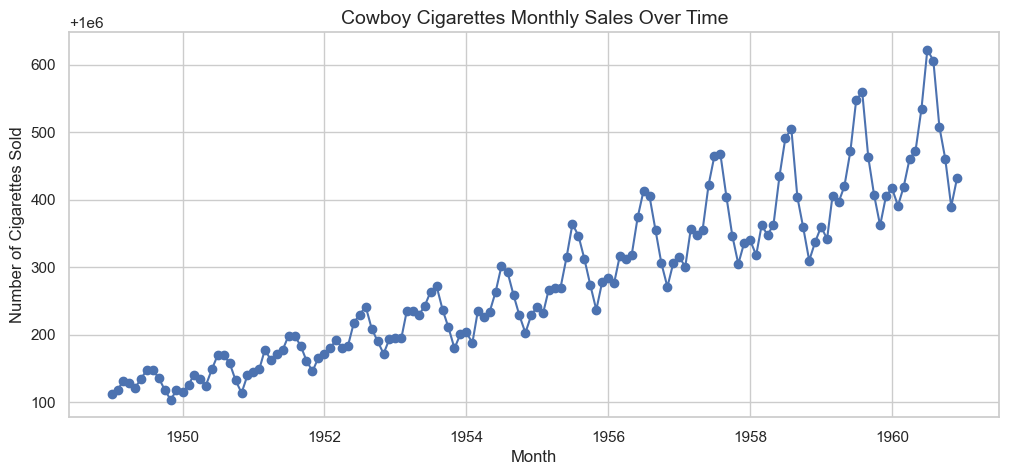

In [36]:
plt.figure(figsize=(12, 5))
plt.plot(y, marker="o", linestyle="-")
plt.title("Cowboy Cigarettes Monthly Sales Over Time", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Number of Cigarettes Sold")
plt.grid(True)
plt.show()

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-------------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

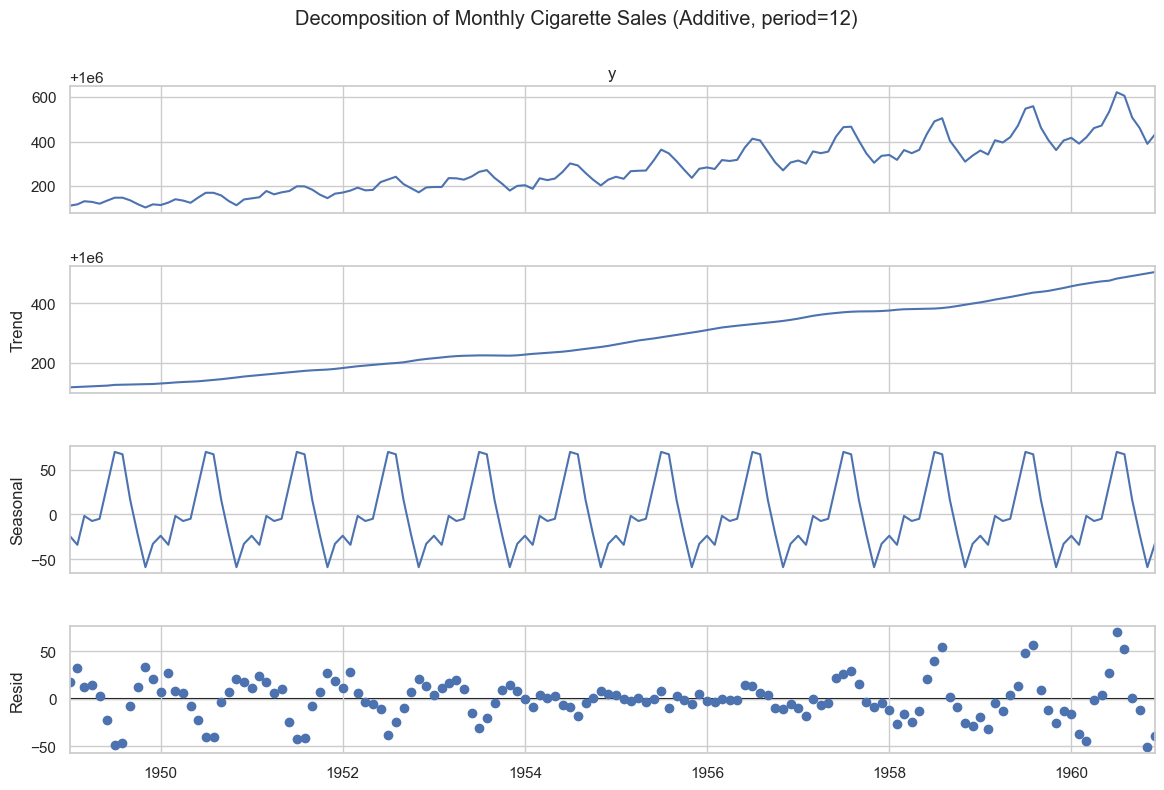

In [40]:
# 3a. Decomposition — trend/seasonal/residual components

from statsmodels.tsa.seasonal import seasonal_decompose

# 1) Ensure a true monthly frequency index (MS = Month Start)
y_m = y.asfreq("MS")

# 2) Handle any missing months (if any): linear interpolation
y_mi = y_m.interpolate(limit_direction="both")

# 3) Decompose (additive is a good default for fairly stable variance)
decomp = seasonal_decompose(y_mi, model="additive", period=12, extrapolate_trend="freq")

# Plot the original data, the trend, the seasonality, and the residuals 
fig = decomp.plot()
fig.set_size_inches(12, 8)
plt.suptitle("Decomposition of Monthly Cigarette Sales (Additive, period=12)", y=1.02)
plt.show()

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [46]:
from statsmodels.tsa.stattools import kpss

# Use the interpolated monthly series (ensures no gaps)
y_kpss = y.asfreq("MS").interpolate(limit_direction="both")

# Perform KPSS test
stat, p_value, n_lags, critical_values = kpss(y_kpss, regression="c", nlags="auto")

print("KPSS Statistic:", round(stat, 4))
print("p-value:", round(p_value, 4))
print("Lags used:", n_lags)
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")

# Interpretation
if p_value < 0.05:
    print("\n Result: Reject H₀ — The series is **not stationary** (has trend or unit root).")
else:
    print("\n Result: Fail to reject H₀ — The series is **stationary**.")

KPSS Statistic: 1.6513
p-value: 0.01
Lags used: 8
Critical Values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739

 Result: Reject H₀ — The series is **not stationary** (has trend or unit root).


/var/folders/rg/qgl1z3mn0gj3j5qjz1gcl5fh0000gn/T/ipykernel_7124/552071863.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p_value, n_lags, critical_values = kpss(y_kpss, regression="c", nlags="auto")


Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

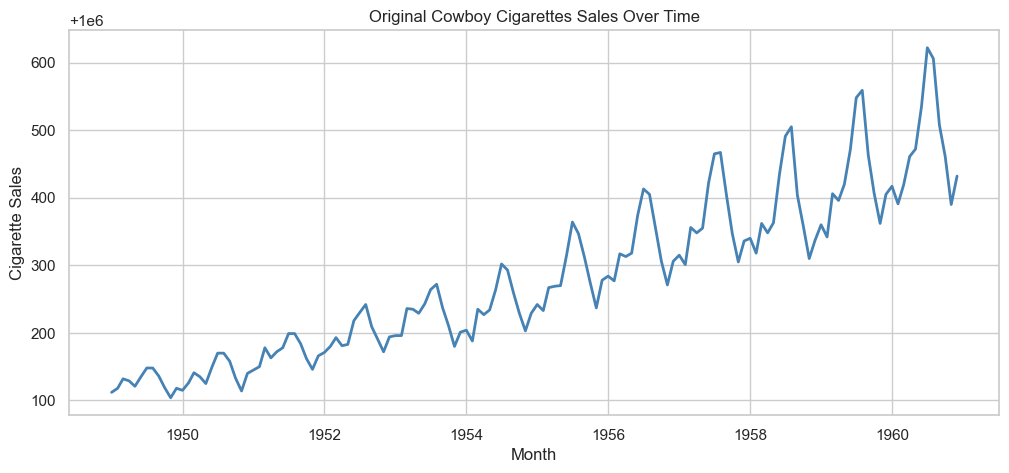

In [54]:
plt.figure(figsize=(12, 5))
plt.plot(y, color="steelblue", linewidth=2)
plt.title("Original Cowboy Cigarettes Sales Over Time")
plt.xlabel("Month")
plt.ylabel("Cigarette Sales")
plt.grid(True)
plt.show()

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

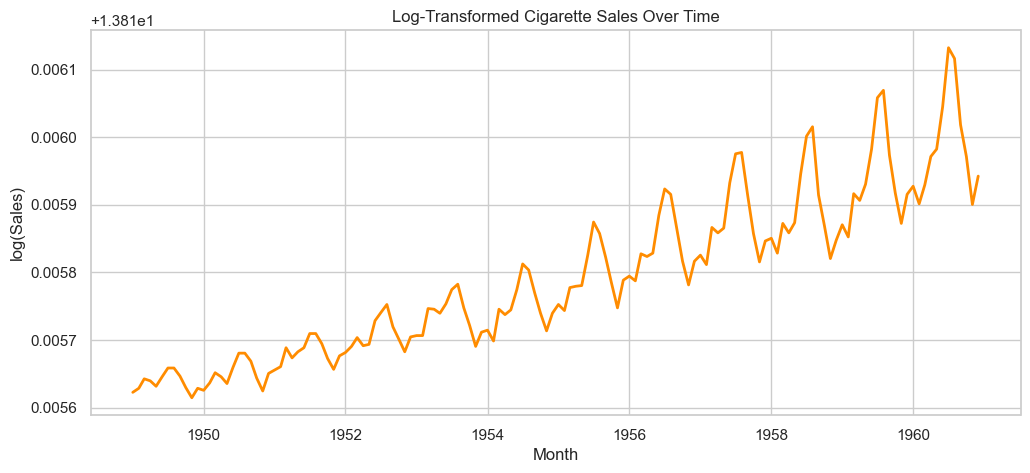

In [56]:
y_log = np.log(y)

plt.figure(figsize=(12, 5))
plt.plot(y_log, color="darkorange", linewidth=2)
plt.title("Log-Transformed Cigarette Sales Over Time")
plt.xlabel("Month")
plt.ylabel("log(Sales)")
plt.grid(True)
plt.show()


When you plot this, you can see how the variance in our data now remains contant over time.

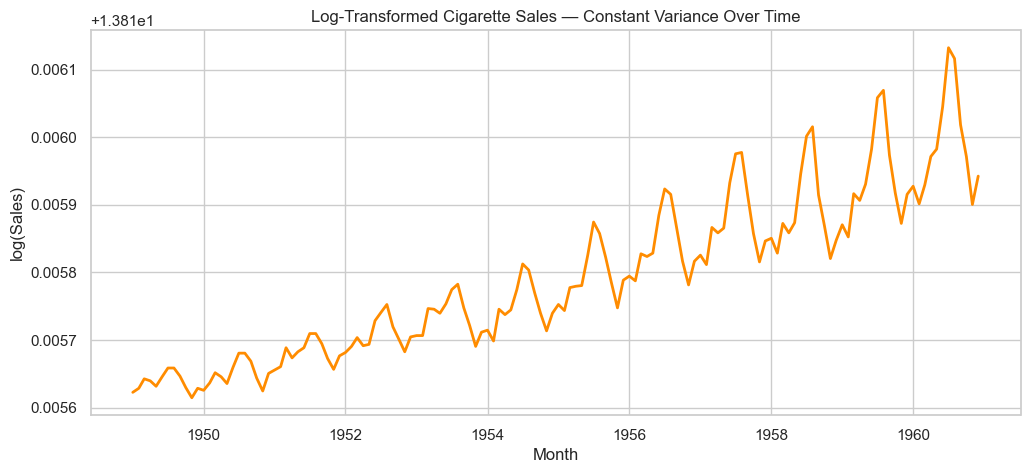

In [58]:
plt.figure(figsize=(12, 5))
plt.plot(y_log, color="darkorange", linewidth=2)
plt.title("Log-Transformed Cigarette Sales — Constant Variance Over Time")
plt.xlabel("Month")
plt.ylabel("log(Sales)")
plt.grid(True)
plt.show()

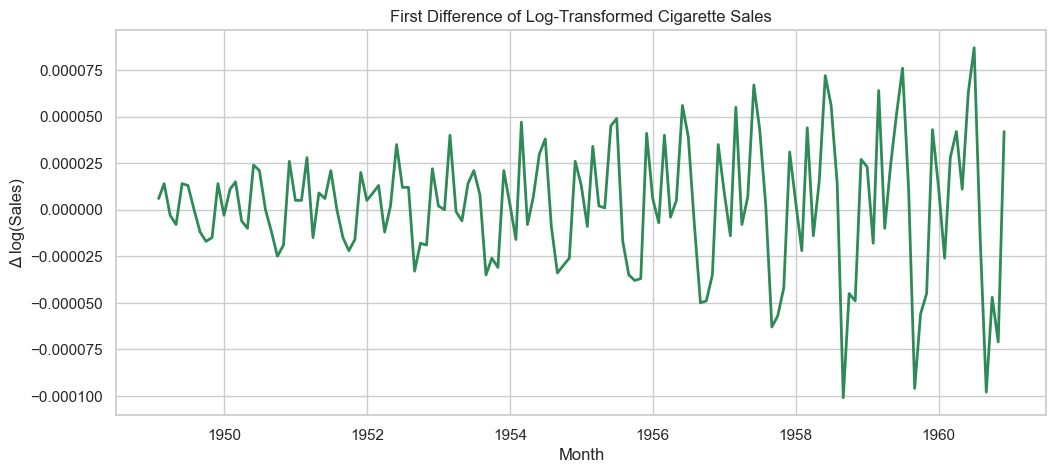

Differencing complete — the mean now appears constant around zero.
Original data points: 144
Differenced data points: 143


In [62]:
y_log_diff = y_log.diff().dropna()

plt.figure(figsize=(12, 5))
plt.plot(y_log_diff, color="seagreen", linewidth=2)
plt.title("First Difference of Log-Transformed Cigarette Sales")
plt.xlabel("Month")
plt.ylabel("Δ log(Sales)")
plt.grid(True)
plt.show()

print("Differencing complete — the mean now appears constant around zero.")
print("Original data points:", len(y_log))
print("Differenced data points:", len(y_log_diff))

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [64]:
stat, p_value, n_lags, critical_values = kpss(y_log_diff, regression="c", nlags="auto")

print("KPSS Statistic:", round(stat, 4))
print("p-value:", round(p_value, 4))
print("Lags used:", n_lags)
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")

# Interpretation
if p_value < 0.05:
    print("\n Result: Reject H₀ — The series is **not stationary**.")
else:
    print("\n Result: Fail to reject H₀ — The series is **stationary**.")

KPSS Statistic: 0.0239
p-value: 0.1
Lags used: 7
Critical Values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739

 Result: Fail to reject H₀ — The series is **stationary**.


/var/folders/rg/qgl1z3mn0gj3j5qjz1gcl5fh0000gn/T/ipykernel_7124/362982566.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p_value, n_lags, critical_values = kpss(y_log_diff, regression="c", nlags="auto")


Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [ ]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

In [68]:
y_log = np.log(y).asfreq("MS").interpolate(limit_direction="both")

# last 12 months as test
h = 12
train_log, test_log = y_log.iloc[:-h], y_log.iloc[-h:]

# Make a function to find the MSE of a single ARIMA model
def arima_mse(order, train_series=train_log, test_series=test_log):
    """
    Fit ARIMA(order) on train_series (log scale), forecast len(test_series) steps,
    and return (MSE_on_level_scale, fitted_result).

    order: tuple (p, d, q)
    """
    try:
        model = ARIMA(train_series, order=order)
        res = model.fit()
        # Forecast on log scale, then exponentiate back to level for an intuitive MSE
        fc_log = res.forecast(steps=len(test_series))
        mse = mean_squared_error(np.exp(test_series), np.exp(fc_log))
        return mse, res
    except Exception as e:
        # Return a very large MSE if the model fails to fit so it won't be selected
        return float("inf"), None

mse_111, _ = arima_mse((1, 1, 1))
print(f"Smoke test — ARIMA(1,1,1) MSE (level scale): {mse_111:.2f}")

Smoke test — ARIMA(1,1,1) MSE (level scale): 8746.04


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [72]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
from itertools import product

def evaluate_arima_grid(p_values=(0,1,2,3), d_values=(0,1), q_values=(0,1,2,3),
                        train_series=None, test_series=None, top_k=5):
    """
    Grid search over ARIMA(p,d,q) using arima_mse(); returns (results_df, best_row, best_result).
    - results_df: sorted by MSE (ascending)
    - best_row: the first row of results_df
    - best_result: the fitted ARIMAResults object for best_row
    """
    assert train_series is not None and test_series is not None, "Provide train and test series."

    rows = []
    best = {"mse": np.inf, "order": None, "res": None}

    for (p, d, q) in product(p_values, d_values, q_values):
        order = (p, d, q)
        mse, res = arima_mse(order, train_series=train_series, test_series=test_series)
        aic = getattr(res, "aic", np.nan) if res is not None else np.nan
        rows.append({"order": order, "MSE": mse, "AIC": aic})

        if mse < best["mse"]:
            best = {"mse": mse, "order": order, "res": res}

    results_df = pd.DataFrame(rows).sort_values("MSE", ascending=True).reset_index(drop=True)
    best_row = results_df.iloc[0]
    return results_df, best_row, best["res"]

# --- Run the grid search ---
p_vals = (0,1,2)
d_vals = (1,)      
q_vals = (0,1,2)

results_df, best_row, best_fit = evaluate_arima_grid(
    p_values=p_vals, d_values=d_vals, q_values=q_vals,
    train_series=train_log, test_series=test_log, top_k=5
)

print("Top results:")
display(results_df.head(5))

print(f"Best ARIMA order: {best_row['order']}  | Test MSE (level): {best_row['MSE']:.2f}  | AIC: {best_row['AIC']:.1f}")

Top results:


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M

,order,MSE,AIC
0,"(2, 1, 1)",7001.789928,-2367.919959
1,"(2, 1, 2)",7612.228667,-2353.209800
2,"(1, 1, 2)",7959.862758,-2359.644198
3,"(1, 1, 0)",8263.867510,-2353.218078
4,"(1, 1, 1)",8746.042242,-2348.022457


Best ARIMA order: (2, 1, 1)  | Test MSE (level): 7001.79  | AIC: -2367.9


In [74]:
# Now, we choose a couple of values to try for each parameter.
# Choose candidate values for p, d, q
p_values = [0, 1, 2]
d_values = [1]          # KPSS indicated d=1
q_values = [0, 1, 2]

print("Grid:")
print("p:", p_values, "| d:", d_values, "| q:", q_values)


Grid:
p: [0, 1, 2] | d: [1] | q: [0, 1, 2]


In [76]:
# Finally, we can find the optimum ARIMA model for our data.
# Run the grid search using the helper we defined earlier (evaluate_arima_grid)
results_df, best_row, best_fit = evaluate_arima_grid(
    p_values=p_values, d_values=d_values, q_values=q_values,
    train_series=train_log, test_series=test_log, top_k=5
)

print("Top results:")
display(results_df.head(5))

best_order = tuple(best_row["order"])
print(f"Best ARIMA order: {best_order} | Test MSE (level): {best_row['MSE']:.2f} | AIC: {best_row['AIC']:.1f}")

Top results:


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M

,order,MSE,AIC
0,"(2, 1, 1)",7001.789928,-2367.919959
1,"(2, 1, 2)",7612.228667,-2353.209800
2,"(1, 1, 2)",7959.862758,-2359.644198
3,"(1, 1, 0)",8263.867510,-2353.218078
4,"(1, 1, 1)",8746.042242,-2348.022457


Best ARIMA order: (2, 1, 1) | Test MSE (level): 7001.79 | AIC: -2367.9


So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

In [78]:
y_log_full = np.log(y).asfreq("MS").interpolate(limit_direction="both")
final_model = ARIMA(y_log_full, order=best_order)
final_res = final_model.fit()

print("Model fitted with order:", best_order)

Model fitted with order: (2, 1, 1)


We can take a look at a summary of the model this library has built around our data.

In [80]:
final_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1287.245
Date:                Wed, 12 Nov 2025   AIC                          -2566.490
Time:                        11:19:57   BIC                          -2554.639
Sample:                    01-01-1949   HQIC                         -2561.674
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0575   1.33e-19   7.98e+18      0.000       1.057       1.057
ar.L2         -0.4391   7.17e-19  -6.12e+17      0.000      -0.439      -0.439
ma.L1         -0.7080   3.89e-20  -1.82e+19      0.000      -0.708      -0.708
sigma2      7.158e-10   2.65e-10      2.705      0.007    1.97e-10    1.23e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):                 0.63
Prob(Q):                              0.40   Prob(JB):                         0.73
Heteroskedasticity (H):               7.95   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.46e+36. Standard errors may be unstable.
"""

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

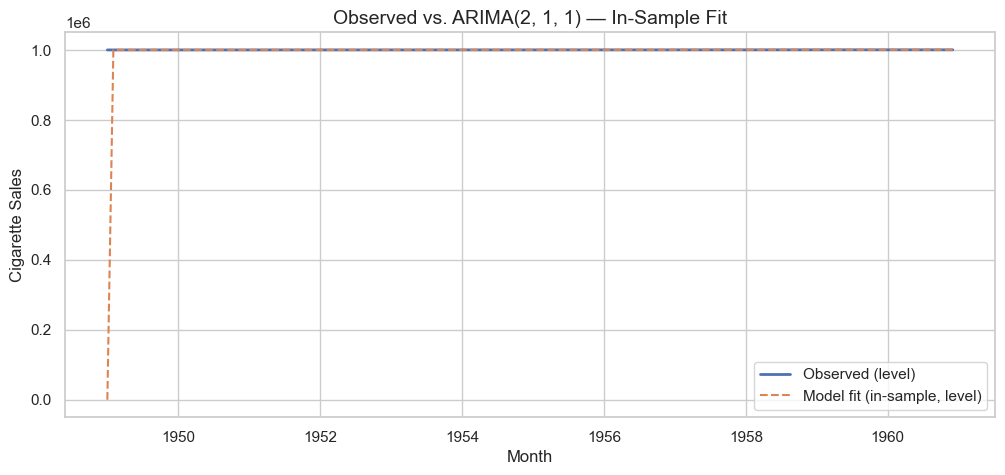

In [84]:
# Original series in level units (ensure monthly frequency)
y_level = y.asfreq("MS").interpolate(limit_direction="both")

# Get in-sample fitted values on log scale and back-transform
pred = final_res.get_prediction()
pred_log = pred.predicted_mean
fitted_level = np.exp(pred_log).dropna()

# Align indexes
common_idx = y_level.index.intersection(fitted_level.index)

# Use the known best order tuple for the title
order_str = f"ARIMA{best_order}"

plt.figure(figsize=(12, 5))
plt.plot(y_level.loc[common_idx], label="Observed (level)", linewidth=2)
plt.plot(fitted_level.loc[common_idx], label="Model fit (in-sample, level)", linestyle="--")
plt.title(f"Observed vs. {order_str} — In-Sample Fit", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Cigarette Sales")
plt.grid(True)
plt.legend()
plt.show()

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

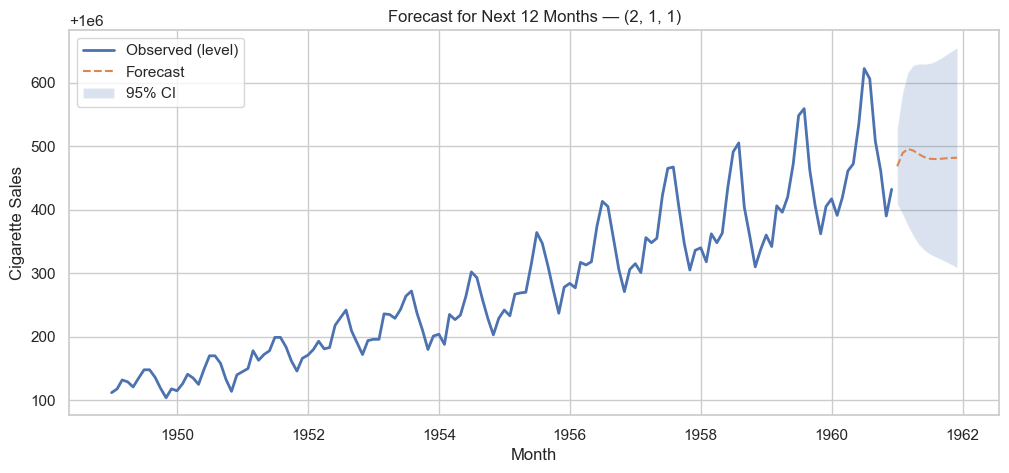

In [90]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 12  # months to forecast

# Ensure we have a clean monthly series to anchor the future index
y_level = y.asfreq("MS").interpolate(limit_direction="both")

# Create a range of future dates (monthly starts) right after the last observed month
future_index = pd.date_range(
    start=y_level.index[-1] + pd.offsets.MonthBegin(1),
    periods=forecast_period,
    freq="MS"
)

future_index[:5]

# Convert that range into a dataframe that includes your predictions
fc = final_res.get_forecast(steps=forecast_period)
fc_mean_log = fc.predicted_mean
fc_ci_log = fc.conf_int()

forecast_df = pd.DataFrame(
    {
        "yhat": np.exp(fc_mean_log.values),
        "yhat_lower": np.exp(fc_ci_log.iloc[:, 0].values),
        "yhat_upper": np.exp(fc_ci_log.iloc[:, 1].values),
    },
    index=future_index,
)
forecast_df.index.name = "Month"

forecast_df.head()

# Plot your future predictions
plt.figure(figsize=(12, 5))
plt.plot(y_level, label="Observed (level)", linewidth=2)

plt.plot(forecast_df.index, forecast_df["yhat"], label="Forecast", linestyle="--")
plt.fill_between(
    forecast_df.index,
    forecast_df["yhat_lower"],
    forecast_df["yhat_upper"],
    alpha=0.2,
    label="95% CI"
)

plt.title(f"Forecast for Next {forecast_period} Months — {best_order}")
plt.xlabel("Month")
plt.ylabel("Cigarette Sales")
plt.grid(True)
plt.legend()
plt.show()


## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 